# Feature Selection

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import svm

In [2]:
# preprocessing function
def preprocessing_data(df: pd.DataFrame):
    data = df.copy()
    # drop NaN values for some columns
    data = data.dropna(subset=['education_level','major_discipline', 'experience', 'last_new_job'])
    # Replace other NaN with Unknown value 
    data = data.replace(np.nan,'Unknown')
    # relevent_experience replace with 0 and 1, 1 for having experience and 0 for no experience
    data['relevent_experience'] = data['relevent_experience'].replace(['Has relevent experience','No relevent experience'],[1,0])

    # manually assign ordinal numbers to education_level and company_size
    # for graduate level I will give 1 and for master 2 and for phd 3. Graduate level can be equals to masters and phd but usually people with phd would not represent themselves as graduate. 
    # any graduate level certificate can be considered as graduate so I will assign a lower number to graduate than masters. 
    # for company_size unknown will get 0.
    
    data['education_level'] = data['education_level'].replace(['Graduate','Masters','Phd'],[1,2,3])
    data['company_size'] = data['company_size'].replace(['Unknown','<10', '10/49','50-99', '100-500','500-999','1000-4999','5000-9999','10000+'] ,range(0,9))

    # convert experience and last_new_job to numeric values
    data['experience'] = data['experience'].str.replace('>','').str.replace('<','')
    data['experience'] = pd.to_numeric(data['experience'])

    data['last_new_job'] = data['last_new_job'].str.replace('>','')
    data['last_new_job'] = data['last_new_job'].replace('never',0)
    data['last_new_job'] = pd.to_numeric(data['last_new_job'])

    data = pd.get_dummies(data, columns = ['company_type', 'enrolled_university', 'gender', 'major_discipline','city'])
    
    #Normalize data using MinMaxScaler function of sci-kit leaern
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data_scaled = pd.DataFrame(x_scaled, columns = data.columns)
    return(data_scaled)

In [3]:
def cor_selector(X, y,num_feats):
    # Your code goes here (Multiple lines)
    cor_list = []
    
    # create a list of all features
    feature_name = X.columns.tolist()
    
    # Calculate the Pearson Correlation using corrcoef in numpy for each two features
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    # replace Nan values with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # we use argsort to show the rank of each correlation in the list after sorting, and we select the last N number of features where N 
    # is the num_feats.
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    
    #indicate whether the faeture is selected or not
    cor_support = [True if i in cor_feature else False for i in feature_name]
    # Your code ends here
    return cor_support, cor_feature

In [5]:
raw_data =  pd.read_csv("resources/aug_train.csv")
processed_data = preprocessing_data(raw_data)
y = processed_data.target
X = processed_data.drop(columns=['target','enrollee_id'])


In [6]:
cor_support, cor_feature = cor_selector(X, y,100)
print(str(len(cor_feature)), 'selected features')

100 selected features


In [7]:
eliminated_features = list(set(X.columns)-set(cor_feature)) 

In [8]:
selected_data = processed_data.drop(columns = eliminated_features)
y = selected_data.target
X = selected_data.drop(columns=['target','enrollee_id'])

In [9]:
# split test-train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
# A function to get the best logistic regression prediction
def get_best_prediction(X_train, X_test, y_train, y_test):
    best_logistic_regression_model = LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='liblinear').fit(X_train, y_train)
    best_prediction = best_logistic_regression_model.predict(X_test)
    return best_prediction

In [13]:
best_prediction = get_best_prediction(X_train, X_test, y_train, y_test)

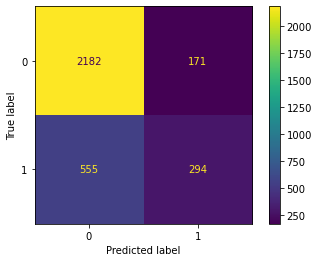

In [15]:
# Confusion matrix with the best logistic regression model GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,best_prediction)).plot()

In [16]:
# f1 score:
from sklearn.metrics import f1_score
print("Logistic regression with feature selections f1 score: ", f1_score(y_test, best_prediction))

Logistic regression with feature selections f1 score:  0.4474885844748859


# 2. Decision Tree

# 3. Random Forest

# 4. SGD

# 5. SVM

In [36]:
model = svm.SVC(C= 1, gamma= 0.1, kernel= 'rbf', random_state=42) 
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test,y_pred)
print("\nF1 Score: ", f1)



F1 Score:  0.5752045311516678


## SVM with weighted class

In [37]:
model = svm.SVC(C= 1, gamma= 0.1, kernel= 'rbf',class_weight={1: 3}, random_state=42) 
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test,y_pred)
print("\nF1 Score: ", f1)



F1 Score:  0.641298833079655
